In [67]:
import msprime
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import scipy.integrate as integrate
import math
import pickle

In [68]:
def rho(j, t, eta):
    return np.exp(-scipy.special.binom(int(j), 2)*integrate.quad(eta, 0, t, limit=100)[0])

def comb_term(j, k, n):
    assert j >= k, "invalid integers"
    return ((-1)**(j-k)*(2*j - 1)*np.prod(list(range(k, k + j -1)))*
            np.prod(list(range(n, n - j, -1)))/
            (math.factorial(k)*math.factorial(j - k)*
             np.prod(list(range(n, n + j)))))

def P_Ant(k, t, n, eta):
    result = 0
    for jj in range(k, n + 1):
        result += (rho(jj, t, eta)*
                   comb_term(jj, k , n))
    return result

def ETj(k, n, eta):
    PP = lambda t: P_Ant(k, t, n, eta)
    return integrate.quad(PP, 0, scipy.inf, limit=100)

In [134]:
def full_pop_reps(Ne_sim, mu, pi, rr=0.0):
    genotypes = []
    c_rate = lambda t: np.exp(rr*2.*Ne_sim*t)
    T2_2 = ETj(2, 2, c_rate)[0] # get the expected pairwise coal time in units of 2Ne
    LL = round(pi / (4.*mu*Ne_sim*T2_2)) # calculate the necessary number of sites
    #print(LL)
    replicates = msprime.simulate(
        mutation_rate=mu,
        num_replicates=LL,
        population_configurations = [msprime.PopulationConfiguration(growth_rate=rr,
                                                                     sample_size=2*Ne_sim,
                                                                     initial_size=Ne_sim)])
    for j, tree_sequence in enumerate(replicates):
        #if not j % 1000:
            #print(j / LL)
        if tree_sequence.get_num_mutations() > 0:
            variant = next(tree_sequence.variants())
            genotypes.append(variant.genotypes)
        if tree_sequence.get_num_mutations() > 1:
            print("Warning: more than one mutation")
    return(np.array(genotypes, dtype=np.int32))

def full_pop_reps_fast(Ne_sim, mu, pi):
    genotypes = []
    replicates = msprime.simulate(
        sample_size=2*Ne_sim, # the coal rate is determined by two times Ne
        Ne=Ne_sim,
        mutation_rate=mu,
        num_replicates=round(pi / (4.*mu*Ne_sim)))
    for j, tree_sequence in enumerate(replicates):
        if tree_sequence.get_num_mutations() > 0:
            variant = next(tree_sequence.variants())
            genotypes.append(variant.genotypes)
        if tree_sequence.get_num_mutations() > 1:
            print("Warning: more than one mutation")
    return(np.array(genotypes, dtype=np.int32))

def nt_div(genotypes):
    result = 0
    psum = 0
    for ii in range(genotypes.shape[1]):
        for jj in range(ii+1, genotypes.shape[1]):
            result += np.sum(np.abs(genotypes[:,ii] - genotypes[:,jj]))
            psum += 1
    return result/psum

def phen_pop(Ne_sim, mu, pi, rr=0.0):
    genotypes = np.transpose(full_pop_reps(Ne_sim, mu, pi, rr=rr))
    while len(genotypes.shape) == 1:
        genotypes = np.transpose(full_pop_reps(Ne_sim, mu, pi, rr=rr))
    return(genotypes * np.random.laplace(size=genotypes.shape[1]))

def pop_kurt(phenotypes):
    phens = np.sum(phenotypes, axis=1)
    mean_phen = np.mean(phens)
    m4 = np.mean((phens - mean_phen)**4)
    m2 = np.var(phens)
    return(m4 / m2**2)

def pop_kurt_alt(phens):
    mean_phen = np.mean(phens)
    m4 = np.mean((phens - mean_phen)**4)
    m2 = np.var(phens)
    return(m4 / m2**2)

def var_sq(phenotypes):
    phens = np.sum(phenotypes, axis=1)
    return(np.var(phens)**2)

In [ ]:
#sim_phens = []
#for ii, pi in enumerate(pi_set):
#    print(pi)
#    sim_phens.append([])
#    for jj in range(nreps[ii]):
#        sim_phens[ii].append(phen_pop(test_Ne, 2e-7, pi))

In [ ]:
#sim_phens_growth = []
#for ii, pi in enumerate(pi_set):
#    print(pi)
#    sim_phens_growth.append([])
#    for jj in range(nreps[ii]):
#        sim_phens_growth[ii].append(phen_pop(test_Ne, 1e-6, pi, rr=test_rr))

In [ ]:
#sim_phens_growth_lap = []
#for ii, pi in enumerate(pi_set):
#    print(pi)
#    sim_phens_growth_lap.append([])
#    for jj in range(nreps[ii]):
#        sim_phens_growth_lap[ii].append(phen_pop(test_Ne, 1e-6, pi, rr=test_rr))

In [76]:
#with open("sim_phens_norm.pyc", "wb") as fout:
#    pickle.dump(sim_phens, file=fout)

In [133]:
#with open("sim_phens_norm_growth.pyc", "wb") as fout:
#    pickle.dump(sim_phens_growth, file=fout)

In [136]:
#with open("sim_phens_lap_growth.pyc", "wb") as fout:
#    pickle.dump(sim_phens_growth_lap, file=fout)

These simulations take a good amount of time to run so read in output already computed:

In [144]:
with open("sim_phens_norm.pyc", "rb") as fin:
     sim_phens_norm = pickle.load(fin)

In [145]:
with open("sim_phens_lap.pyc", "rb") as fin:
    sim_phens_lap = pickle.load(fin)

In [146]:
with open("sim_phens_norm_growth.pyc", "rb") as fin:
    sim_phens_growth_norm = pickle.load(fin)

In [148]:
with open("sim_phens_lap_growth.pyc", "rb") as fin:
    sim_phens_growth_lap = pickle.load(fin)

In [15]:
pop_vars = np.array([np.mean([np.var(np.sum(pp, 1)) for pp in phen]) for phen in sim_phens])
pop_mkurts = np.array([np.mean([pop_kurt_alt(np.sum(pp, 1)) for pp in phen]) for phen in sim_phens])
pop_var_vars = np.array([np.var([np.var(np.sum(pp, 1)) for pp in phen], ddof=1) for phen in sim_phens])

In [16]:
pop_kurtsem = [stats.sem([pop_kurt_alt(np.sum(pp, 1)) for pp in phen]) for phen in sim_phens]

In [17]:
pop_var_vars

array([ 0.10680183,  0.23308137,  0.43084529,  0.45068593,  0.59410291,
        0.94221744,  1.40964672,  2.6113167 ])

In [48]:
pop_kurts_norm = []
for ii, pi in enumerate(pi_set):
    pop_kurts_norm.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_kurts_norm[ii][jj] = pop_kurt(sim_phens_norm[ii][jj])

In [171]:
pop_kurts_lap = []
for ii, pi in enumerate(pi_set):
    pop_kurts_lap.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_kurts_lap[ii][jj] = pop_kurt(sim_phens_lap[ii][jj])

In [142]:
pop_kurts_growth_lap = []
for ii, pi in enumerate(pi_set):
    pop_kurts_growth_lap.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_kurts_growth_lap[ii][jj] = pop_kurt(sim_phens_growth_lap[ii][jj])

In [150]:
pop_kurts_growth_norm = []
for ii, pi in enumerate(pi_set):
    pop_kurts_growth_norm.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_kurts_growth_norm[ii][jj] = pop_kurt(sim_phens_growth_norm[ii][jj])

In [155]:
ET4_4 = ETj(4, 4, lambda t: np.exp(t))[0]
ET3_4 = ETj(3, 4, lambda t: np.exp(t))[0]
ET2_4 = ETj(2, 4, lambda t: np.exp(t))[0]
ET2_2 = ETj(2, 2, lambda t: np.exp(t))[0]
AA = (ET4_4 - (1./6.)*ET3_4 - (1./9.)*ET2_4)/ET2_2
BB = ((1./6.)*ET3_4 + (1./9.)*ET2_4)/ET2_2

/home/evankoch/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
/home/evankoch/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/evankoch/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/home/evankoch/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [156]:
print(AA, BB)

0.09231479183805001 0.1512808680269911


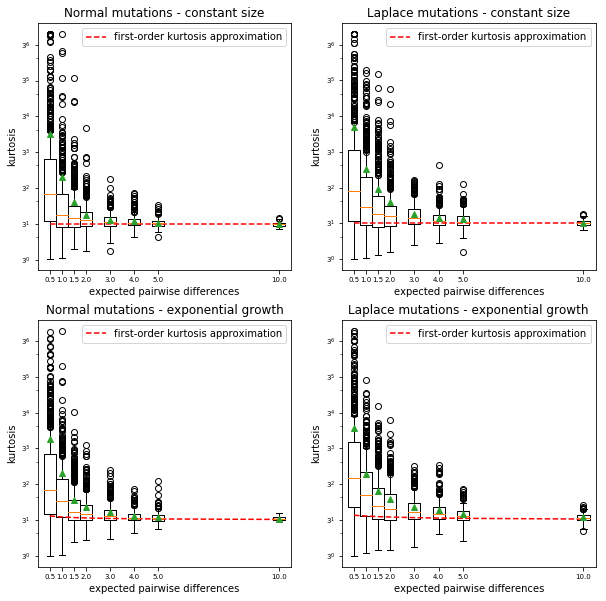

In [187]:
plt.figure(1, figsize=(10, 10))
plt.subplot(221)
plt.boxplot(pop_kurts_norm, positions=pi_set, showmeans=True);
plt.plot(pi_set, [3]*len(pi_set), "--r", label="first-order kurtosis approximation")
plt.tick_params(labelsize=7)
plt.yscale("log", basey=3)
plt.xlabel("expected pairwise differences")
plt.ylabel("kurtosis")
plt.legend()
plt.title("Normal mutations - constant size")

plt.subplot(222)
plt.boxplot(pop_kurts_lap, positions=pi_set, showmeans=True);
plt.plot(pi_set, [3]*len(pi_set), "--r", label="first-order kurtosis approximation")
plt.tick_params(labelsize=7)
plt.yscale("log", basey=3)
plt.xlabel("expected pairwise differences")
plt.ylabel("kurtosis")
plt.legend()
plt.title("Laplace mutations - constant size")

plt.subplot(224)
plt.boxplot(pop_kurts_growth_lap, positions=pi_set, showmeans=True);
plt.plot(pi_set, 3 + 6.*AA/(0.5*np.array(pi_set) + 6.*BB), "--r", label="first-order kurtosis approximation")
plt.tick_params(labelsize=7)
plt.yscale("log", basey=3)
plt.xlabel("expected pairwise differences")
plt.ylabel("kurtosis")
plt.legend()
plt.title("Laplace mutations - exponential growth")

plt.subplot(223)
plt.boxplot(pop_kurts_growth_norm, positions=pi_set, showmeans=True);
plt.plot(pi_set, 3 + 3.*AA/(0.5*np.array(pi_set) + 3.*BB), "--r", label="first-order kurtosis approximation")
plt.tick_params(labelsize=7)
plt.yscale("log", basey=3)
plt.xlabel("expected pairwise differences")
plt.ylabel("kurtosis")
plt.legend()
plt.title("Normal mutations - exponential growth")
plt.savefig("norm_growth_kurt_sim.pdf", bbox_inches="tight")
plt.savefig("kurt_sim.pdf", bbox_inches="tight")